In [1]:
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator
from qiskit_aer import AerSimulator
service = QiskitRuntimeService()
real_backend = service.backend("ibm_brisbane")
aer = AerSimulator.from_backend(real_backend)
estimator = Estimator(backend=aer)

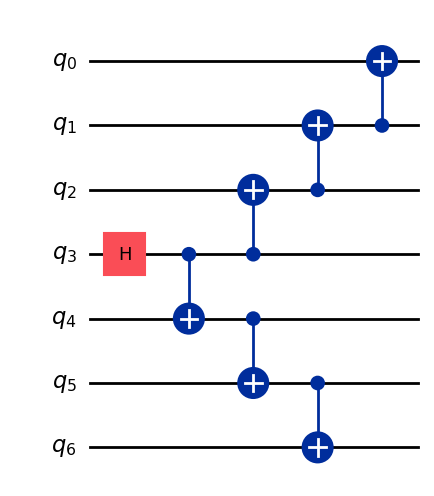

In [2]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
 
# Create a new circuit with two qubits
qc = QuantumCircuit(7)
num_qubit=7                   
qc.h(3)
qc.cx(3,4)
qc.cx(3,2)

qc.cx(4,5)
qc.cx(2,1)
qc.cx(1,0)
qc.cx(5,6)
qc.draw("mpl")

In [3]:
#observable = SparsePauliOp(["ZIIIIII"])
observables=[]
coeffs=[]
num_qubit=7
for i in range(num_qubit):
    obs='I'*(i)+ 'Z'+ 'I'*(num_qubit-i-1)
    observables.append(obs)
    coeffs.append(1/num_qubit)
observable = SparsePauliOp(observables, coeffs=coeffs)
observable

SparsePauliOp(['ZIIIIII', 'IZIIIII', 'IIZIIII', 'IIIZIII', 'IIIIZII', 'IIIIIZI', 'IIIIIIZ'],
              coeffs=[0.14285714+0.j, 0.14285714+0.j, 0.14285714+0.j, 0.14285714+0.j,
 0.14285714+0.j, 0.14285714+0.j, 0.14285714+0.j])

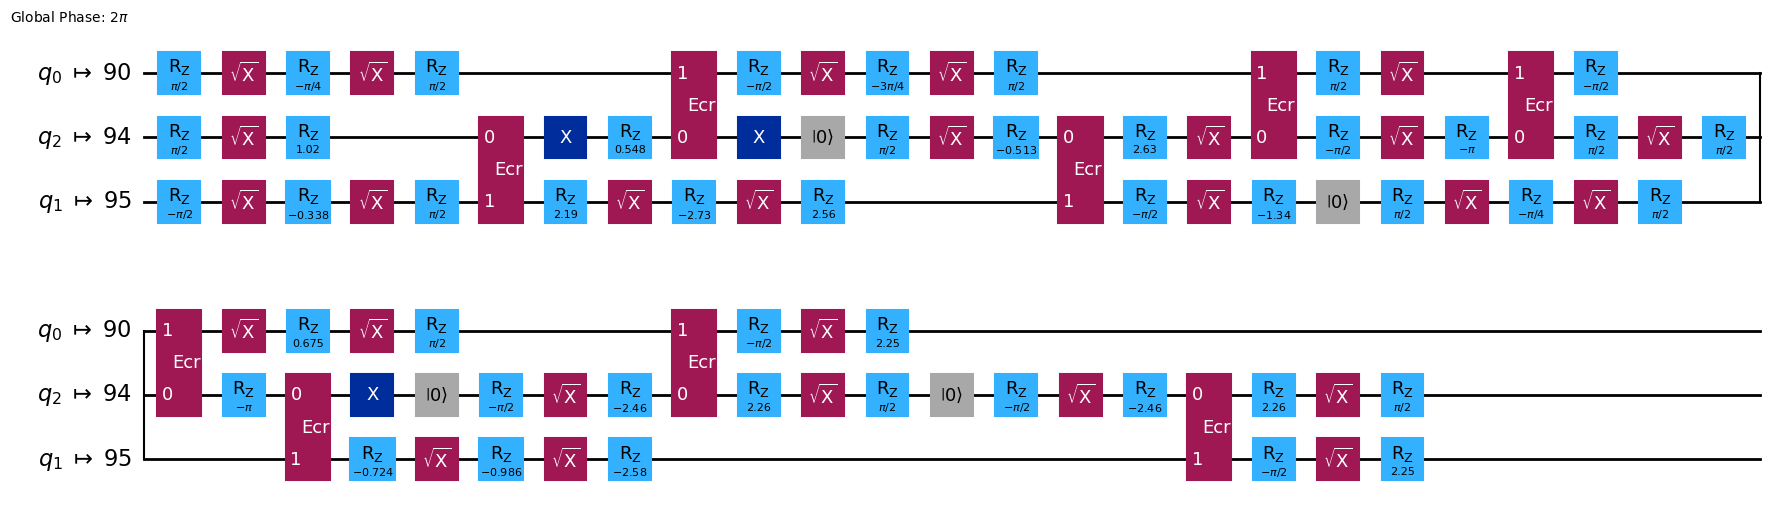

In [4]:
# Convert to an ISA circuit and layout-mapped observables.
pm = generate_preset_pass_manager(backend=aer, optimization_level=2,init_method="qubit_reuse")
isa_circuit = pm.run(qc)
 
isa_circuit.draw('mpl', idle_wires=False)

In [5]:
final_layout = isa_circuit._layout.final_layout
#final_layout

In [6]:
isa_circuit.depth()

45

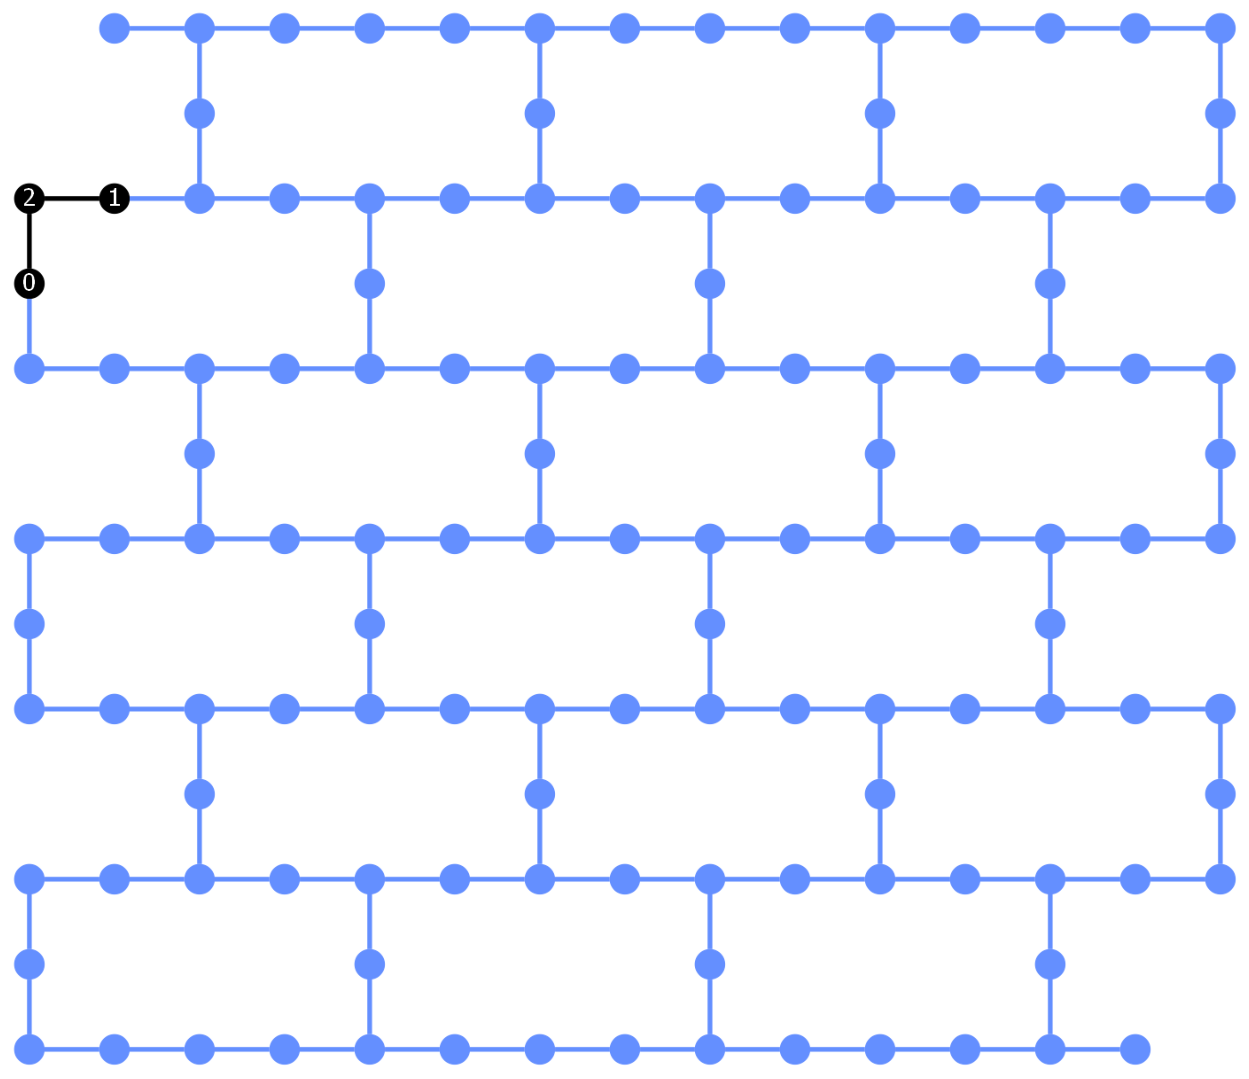

In [7]:
from qiskit.visualization import plot_circuit_layout
plot_circuit_layout(isa_circuit, aer)

In [8]:
# Construct the Estimator instance.
from qiskit_ibm_runtime import EstimatorV2 as Estimator
 
estimator = Estimator(backend=aer)
#estimator.options.resilience_level = 1
#estimator.options.default_shots = 5000
 
isa_observables = observable.apply_layout(isa_circuit.layout)
 
# One pub, with one circuit to run against five different observables.
job = estimator.run([(isa_circuit, isa_observables)])
result = job.result()
pub_result = job.result()[0]

In [9]:
pub_result.data.evs

array(0.54471261)

In [10]:
import json
data = {
    "Ideal expectation Value" : 0,
     "experiment 4":{"name": "25 Aug 7 qubit GHZ state qubit reuse version without cut noisy exp value",
    "obtained expectation value" : pub_result.data.evs.tolist(),"depth":isa_circuit.depth()},

    
    }


with open("25 Aug whether cut unroll combined then cut is useful.json", "w") as f:
    json.dump(data, f, indent=4)